In [1]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
import random
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from PALM.utils import Perf

In [2]:
def create_nested_dict2(keys1, keys2):
    d = dict.fromkeys(keys1)
    for k, v in d.items():
        d[k] = {x: [] for x in keys2}
    return d

def create_nested_dict3(keys1, keys2, keys3):
    d = dict.fromkeys(keys1)
    for k, v in d.items():
        d[k] = dict.fromkeys(keys2)
        for k2 in d[k].keys():
            d[k][k2] = {x: [] for x in keys3}
    return d

def create_nested_dict4(keys1, keys2, keys3, keys4):
    d = dict.fromkeys(keys1)
    for k1, v in d.items():
        d[k1] = dict.fromkeys(keys2)
        for k2 in d[k1].keys():
            d[k1][k2] = dict.fromkeys(keys3)
            for k3 in d[k1][k2].keys():
                d[k1][k2][k3] = {x: [] for x in keys4}
    return d

def reverse_dict_keys(d):
    key1 = list(d.keys())
    key2 = list(d[key1[0]].keys())
    key3 = list(d[key1[0]][key2[0]].keys())
    new_d = {k1: {k3: {k2: d[k1][k2][k3] for k2 in key2} for k3 in key3} for k1 in key1}
    return new_d

# Supplemental simulation results

In [3]:
out_root = '../simu/tree'
data_root = '../simu/tree'

## 1. Computational time and optimal iterations
- Investigate how much D (number of annotations), M (number of SNPs), F (ground-truth function), J (tree depth) influence the computational time and optimal iterations.
- D = {10, 50, 100}, M = {5000, 10000, 15000}, J = {1, 2}.
- Fix F = D, K = 2, nrep = 30, max_iter = 5000 (if optimal iterations are far from 5000, the following simulations can set smaller max_iter). 
- Generate data in discriminative manner.
- Result: With same max_iter and folds, computational time is approximately linearly related to both M and D.

In [4]:
# Performance
Ms = [5000, 10000, 15000]
Ds = [10, 30, 50]
Js = [1, 2]
Func_name = 'Func_D'
K = 2
v = 0.1
gam = 0
lam = 0
nrep = 30
out_dir = os.path.join(out_root, f'time_K{K}')
times = create_nested_dict3(Js, Ms, Ds)
opt_iters = create_nested_dict3(Js, Ms, Ds)

In [5]:
for J in Js:
    for M in Ms:
        for D in Ds:
            for r in range(1, nrep+1):
                time = pd.read_csv(f'{out_dir}/M{M}-D{D}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-times.csv', sep='\t')
                cv_df = pd.read_csv(f'{out_dir}/M{M}-D{D}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-cv.csv', sep='\t')
                avg_Lq = np.mean(cv_df.values, axis=1)
                opt_iter = np.argmax(avg_Lq[1:]) + 1
                times[J][M][D].append(time['time'].sum())
                opt_iters[J][M][D].append(opt_iter)

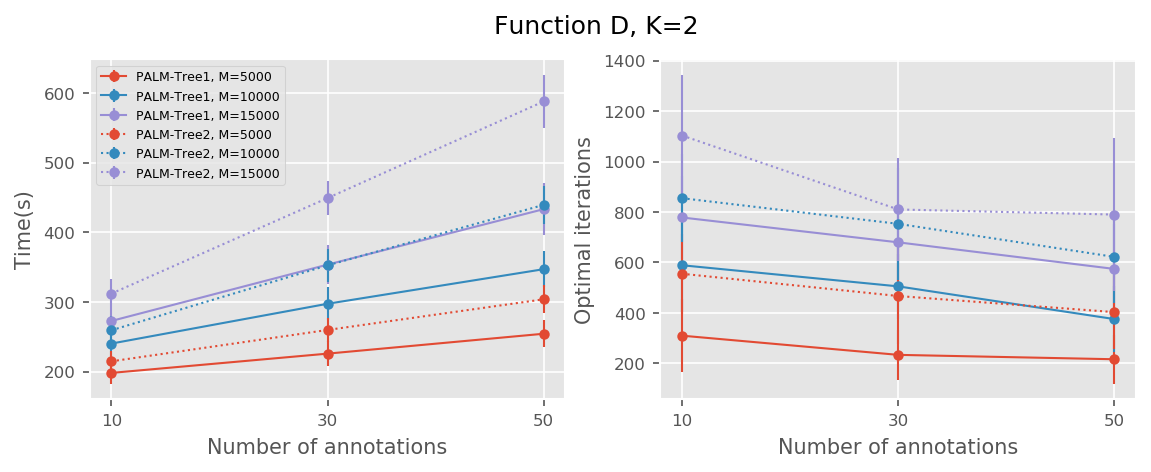

In [6]:
# Varying D: linear
ms = 4
lw = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
for J in Js:
    if J == 1: 
        ls = '-'
    else:
        ls = 'dotted'
    for i, M in enumerate(Ms):
        mean1 = [np.mean(times[J][M][D]) for D in times[J][M].keys()]
        std1 = [np.std(times[J][M][D]) for D in times[J][M].keys()]
        ax[0].errorbar(Ds, mean1, yerr=std1, color=f'C{i}', marker='o', markersize=ms, linestyle=ls, linewidth=lw, label=f'PALM-Tree{J}, M={M}')
        mean2 = [np.mean(opt_iters[J][M][D]) for D in opt_iters[J][M].keys()]
        std2 = [np.std(opt_iters[J][M][D]) for D in opt_iters[J][M].keys()]
        ax[1].errorbar(Ds, mean2, yerr=std2, color=f'C{i}', marker='o', markersize=ms, linestyle=ls, linewidth=lw)
for i in range(2):
    ax[i].set_xticks(Ds)
    ax[i].set_xlabel('Number of annotations', fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    if i == 1:
        ax[i].set_ylabel('Optimal iterations', fontsize=10)
        # ax[i].legend(prop={'size': 6}, bbox_to_anchor=(1, 0.6))
    else:
        ax[i].legend(prop={'size':6})
        ax[i].set_ylabel('Time(s)', fontsize=10)
plt.suptitle(f"Function {Func_name.split('_')[1]}, K={K}", fontsize=12)
plt.show()

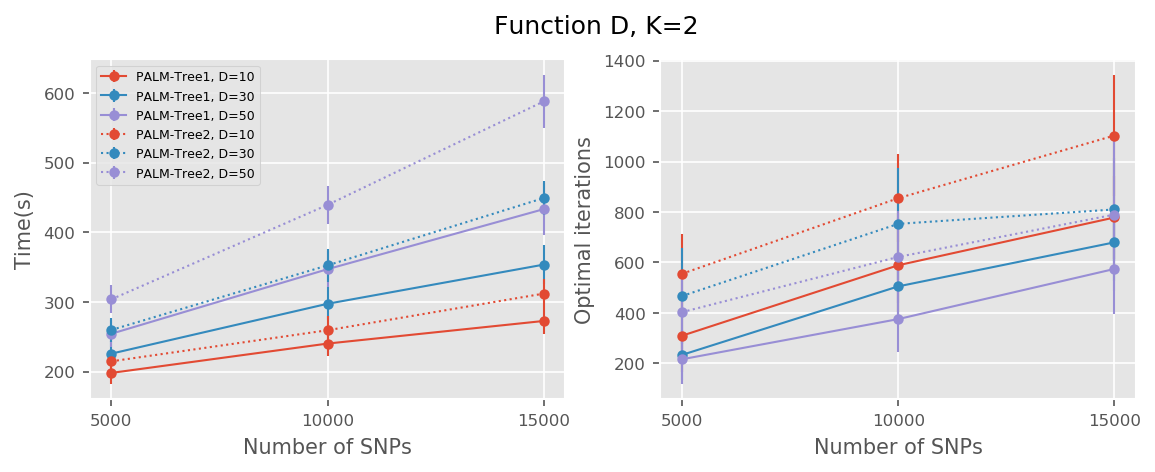

In [7]:
# Varying M: linear
rev_times = reverse_dict_keys(times)
rev_opt_iters = reverse_dict_keys(opt_iters)
ms = 4
lw = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
for J in Js:
    if J == 1: 
        ls = '-'
    else:
        ls = 'dotted'
    for i, D in enumerate(Ds):
        mean1 = [np.mean(rev_times[J][D][M]) for M in rev_times[J][D].keys()]
        std1 = [np.std(rev_times[J][D][M]) for M in rev_times[J][D].keys()]
        ax[0].errorbar(Ms, mean1, yerr=std1, color=f'C{i}', marker='o', markersize=ms, linestyle=ls, linewidth=lw, label=f'PALM-Tree{J}, D={D}')
        mean2 = [np.mean(rev_opt_iters[J][D][M]) for M in rev_opt_iters[J][D].keys()]
        std2 = [np.std(rev_opt_iters[J][D][M]) for M in rev_opt_iters[J][D].keys()]
        ax[1].errorbar(Ms, mean2, yerr=std2, color=f'C{i}', marker='o', markersize=ms, linestyle=ls, linewidth=lw)
for i in range(2):
    ax[i].set_xticks(Ms)
    ax[i].set_xlabel('Number of SNPs', fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    if i == 1:
        ax[i].set_ylabel('Optimal iterations', fontsize=10)
        # ax[i].legend(prop={'size': 6}, bbox_to_anchor=(1, 0.6))
    else:
        ax[i].legend(prop={'size':6})
        ax[i].set_ylabel('Time(s)', fontsize=10)
plt.suptitle(f"Function {Func_name.split('_')[1]}, K={K}", fontsize=12)
plt.show()

## 2. Number of CV folds
- Investigate the influence of number of folds.
- Fix M = 10000, D = 10, nrep = 30, max_iter = 3000.
- Set K = {2, 5}, F = {B, C, D}, J = {1, 2}.
- Compare performances of different K's.
- Result: FDR control is robust to number of folds while 5-fold CV is slightly better than 2-fold CV. Similar with power.

In [8]:
# Performance
M = 10000
D = 10
nrep = 30
Ks = [2, 5]
Func_names = ['Func_B', 'Func_C', 'Func_D']
Js = [1, 2]
v, lam, gam = 0.1, 0, 0
max_iter = 3000
out_dir = os.path.join(out_root, f'folds_M{M}_D{D}')
FDRs = create_nested_dict3(Ks, Js, Func_names)
powers = create_nested_dict3(Ks, Js, Func_names)
AUCs = create_nested_dict3(Ks, Js, Func_names)
pAUCs = create_nested_dict3(Ks, Js, Func_names)
times = create_nested_dict3(Ks, Js, Func_names)
opt_iters = create_nested_dict3(Ks, Js, Func_names)

In [9]:
for K in Ks:
    for J in Js:
        for Func_name in Func_names:
            for r in range(1, nrep+1):
                ret_opt = pd.read_csv(f'{out_dir}/{K}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-prioritize.csv', sep='\t')
                time = pd.read_csv(f'{out_dir}/{K}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-times.csv', sep='\t')
                cv_df = pd.read_csv(f'{out_dir}/{K}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-cv.csv', sep='\t')
                avg_Lq = np.mean(cv_df.values, axis=1)
                opt_iter = np.argmax(avg_Lq[1:]) + 1
                est_Z = ret_opt['assoc'] # risk SNPs have been identified
                perf = Perf(ret_opt['Z'], est_Z, 1 - ret_opt['post']) # FDR, power, AUC, pAUC
                FDRs[K][J][Func_name].append(perf['FDR'])
                powers[K][J][Func_name].append(perf['power']) 
                AUCs[K][J][Func_name].append(perf['AUC'])
                pAUCs[K][J][Func_name].append(perf['pAUC'])
                times[K][J][Func_name].append(time['time'].sum())
                opt_iters[K][J][Func_name].append(opt_iter)

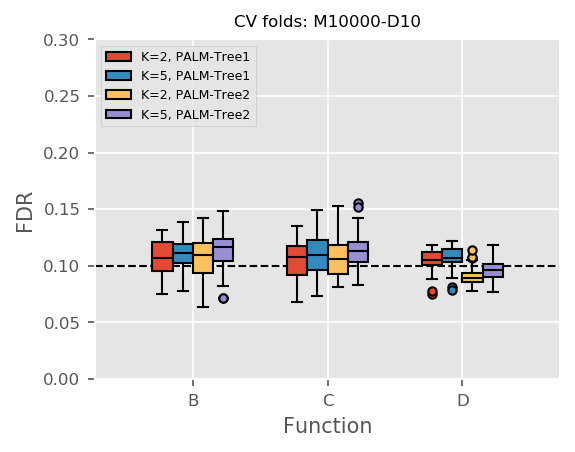

In [10]:
# FDR
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(FDRs[2][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(FDRs[5][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(FDRs[2][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(FDRs[5][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('FDR', fontsize=fs)
ax.axhline(y=0.1, color='black', ls='--', lw=1)
ax.set_ylim([0, 0.3])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
             labels=["K=2, PALM-Tree1", "K=5, PALM-Tree1", "K=2, PALM-Tree2", "K=5, PALM-Tree2"],
             loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'CV folds: M{M}-D{D}', fontsize=8)
plt.show()

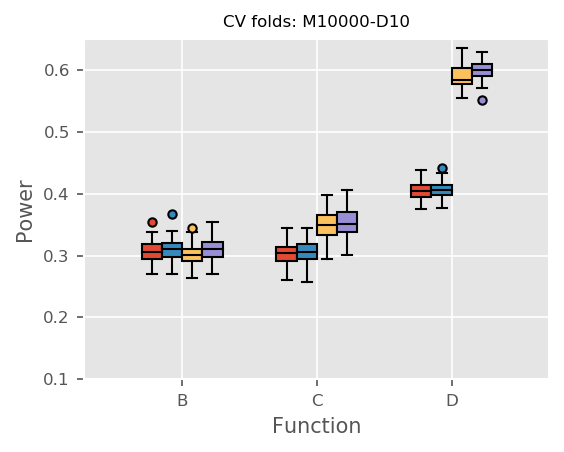

In [11]:
# Power
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(powers[2][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(powers[5][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(powers[2][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(powers[5][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Power', fontsize=fs)
ax.set_ylim([0.1, 0.65])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["K=2, PALM-Tree1", "K=5, PALM-Tree1", "K=2, PALM-Tree2", "K=5, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'CV folds: M{M}-D{D}', fontsize=8)
plt.show()

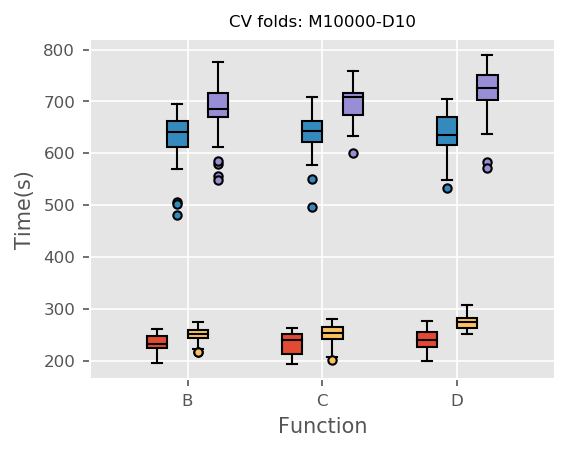

In [12]:
# Time
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(times[2][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(times[5][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(times[2][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(times[5][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Time(s)', fontsize=fs)
# ax.set_ylim([150, 1000])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["K=2, PALM-Tree1", "K=5, PALM-Tree1", "K=2, PALM-Tree2", "K=5, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6}, bbox_to_anchor=(1, 0.6))
plt.title(f'CV folds: M{M}-D{D}', fontsize=8)
plt.show()

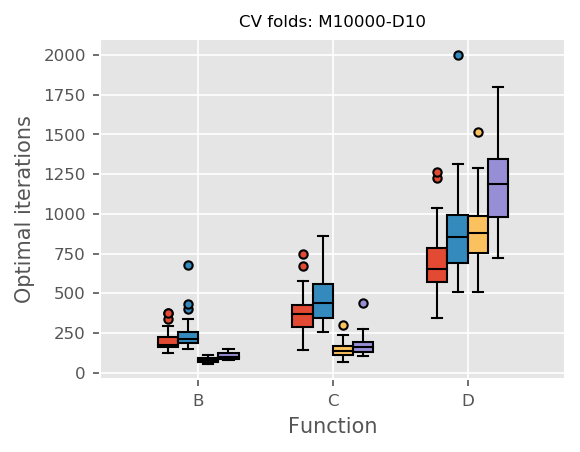

In [13]:
# Optimal iterations
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(opt_iters[2][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(opt_iters[5][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(opt_iters[2][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(opt_iters[5][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Optimal iterations', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["K=2, PALM-Tree1", "K=5, PALM-Tree1", "K=2, PALM-Tree2", "K=5, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'CV folds: M{M}-D{D}', fontsize=8)
plt.show()

## 3. Initial values and parameter estimation
- Investigate how much the initial alpha (beta distribution shape parameter) and f0 (constant in prior model) influence the performance and optimal iterations.
- Compare default setting (can observe parameter estimation result) with random setting.
- Default setting: alpha = 0.4, f0 = -3.
- Random setting: alpha = U[0.1, 0.6], f0 = logit(U[0, 0.3]) (refer to LSMM).
- Fix K = 2, M = 10000, D = 10, nrep = 30, max_iter = 3000.
- Generate data in generative manner: true alpha = {0.2, 0.4, 0.6}, F = {B, C, D}, J = {1, 2}.
- Evaluate performance, parameter estimation (alpha), optimal iterations.
- Result: when heritability is high, alpha estimation and FDR control is robust; when heritability is very low, alpha estimation is influenced by initial value choice and FDR is not guaranteed to be controlled.

In [14]:
# Performance
M, D, K = 10000, 10, 2
nrep = 30
max_iter = 3000
true_alphas = [0.2, 0.4, 0.6]
Func_names = ['Func_B', 'Func_C', 'Func_D']
Js = [1, 2]
modes = ['default', 'random']
out_dir = os.path.join(out_root, f'initial_M{M}_D{D}_K{K}')
alphas = create_nested_dict4(true_alphas, modes, Js, Func_names)
FDRs = create_nested_dict4(true_alphas, modes, Js, Func_names)
powers = create_nested_dict4(true_alphas, modes, Js, Func_names)
AUCs = create_nested_dict4(true_alphas, modes, Js, Func_names)
pAUCs = create_nested_dict4(true_alphas, modes, Js, Func_names)
opt_iters = create_nested_dict4(true_alphas, modes, Js, Func_names)

In [15]:
for true_alpha in true_alphas:
    for mode in modes:
        for J in Js:
            for Func_name in Func_names:
                for r in range(1, nrep+1):
                    alpha = pd.read_csv(f'{out_dir}/alpha{true_alpha}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-{mode}-PALM-tree-alpha.csv', sep='\t')                
                    ret_opt = pd.read_csv(f'{out_dir}/alpha{true_alpha}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-{mode}-PALM-tree-prioritize.csv', sep='\t')                
                    cv_df = pd.read_csv(f'{out_dir}/alpha{true_alpha}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-{mode}-PALM-tree-cv.csv', sep='\t')                
                    avg_Lq = np.mean(cv_df.values, axis=1)
                    opt_iter = np.argmax(avg_Lq[1:]) + 1
                    est_Z = ret_opt['assoc'] # risk SNPs have been identified
                    perf = Perf(ret_opt['Z'], est_Z, 1 - ret_opt['post']) # FDR, power, AUC, pAUC
                    FDRs[true_alpha][mode][J][Func_name].append(perf['FDR'])
                    powers[true_alpha][mode][J][Func_name].append(perf['power']) 
                    AUCs[true_alpha][mode][J][Func_name].append(perf['AUC'])
                    pAUCs[true_alpha][mode][J][Func_name].append(perf['pAUC'])
                    opt_iters[true_alpha][mode][J][Func_name].append(opt_iter)
                    alphas[true_alpha][mode][J][Func_name].append(alpha['alpha'].values[-1])

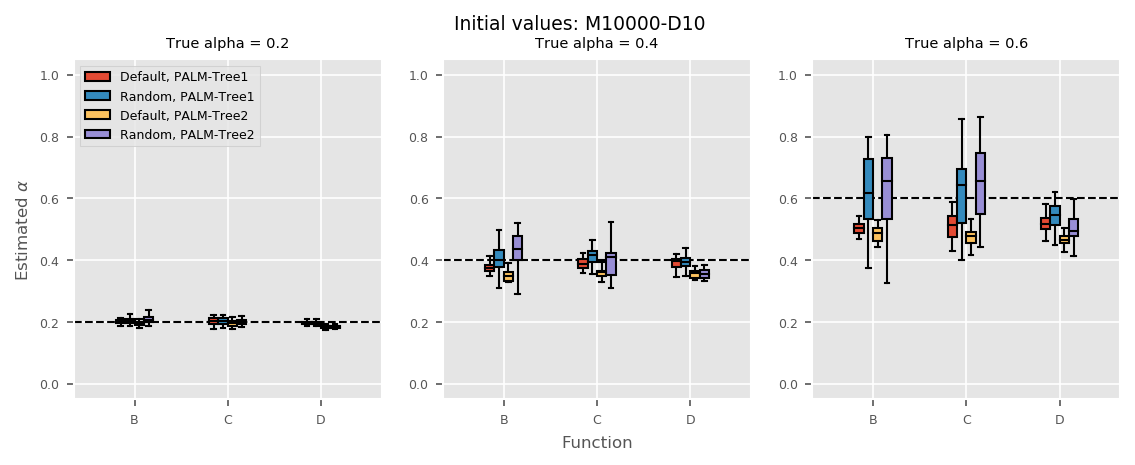

In [16]:
# alpha estimation
plt.style.use('ggplot')
width = 0.1
lw = 0.1
ms = 0
fs = 8
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
for i, true_alpha in enumerate(true_alphas):
    bp11 = ax[i].boxplot(np.vstack(list(alphas[true_alpha]['default'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
    bp12 = ax[i].boxplot(np.vstack(list(alphas[true_alpha]['random'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
    bp21 = ax[i].boxplot(np.vstack(list(alphas[true_alpha]['default'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
    bp22 = ax[i].boxplot(np.vstack(list(alphas[true_alpha]['random'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

    ax[i].set_xticks(np.arange(len(Func_names)))
    ax[i].set_xticklabels([x.split('_')[1] for x in Func_names])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].axhline(y=true_alpha, color='black', ls='--', lw=1)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].set_title(f'True alpha = {true_alpha}', fontsize=7)
    if i == 1:
        ax[i].set_xlabel('Function', fontsize=fs)
    if i == 0:
        ax[i].set_ylabel(r'Estimated $\alpha$', fontsize=fs)
        ax[i].legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
                     labels=["Default, PALM-Tree1", "Random, PALM-Tree1", "Default, PALM-Tree2", "Random, PALM-Tree2"],
                     loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.suptitle(f'Initial values: M{M}-D{D}', fontsize=9)
plt.show()

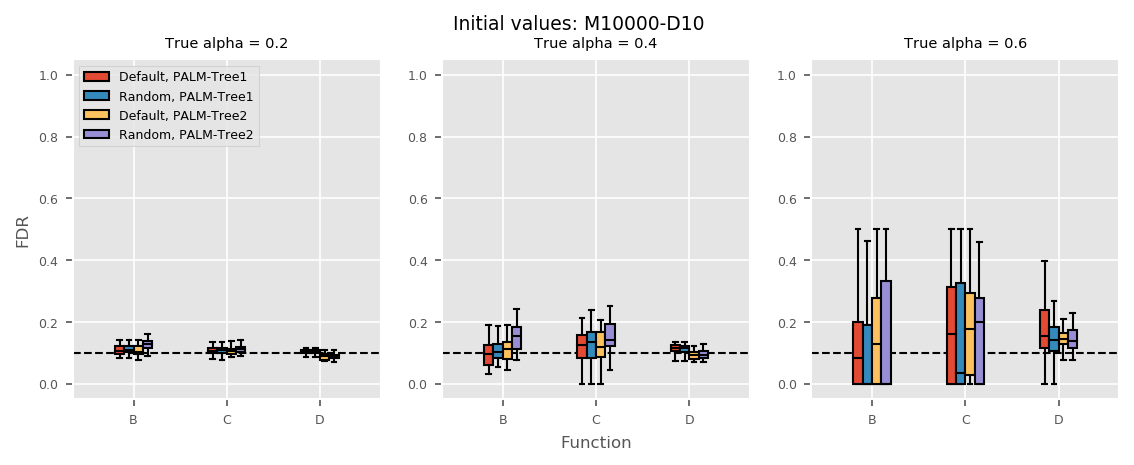

In [17]:
# FDR
plt.style.use('ggplot')
width = 0.1
lw = 0.1
ms = 0
fs = 8
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
for i, true_alpha in enumerate(true_alphas):
    bp11 = ax[i].boxplot(np.vstack(list(FDRs[true_alpha]['default'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
    bp12 = ax[i].boxplot(np.vstack(list(FDRs[true_alpha]['random'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
    bp21 = ax[i].boxplot(np.vstack(list(FDRs[true_alpha]['default'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
    bp22 = ax[i].boxplot(np.vstack(list(FDRs[true_alpha]['random'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

    ax[i].set_xticks(np.arange(len(Func_names)))
    ax[i].set_xticklabels([x.split('_')[1] for x in Func_names])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].axhline(y=0.1, color='black', ls='--', lw=1)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].set_title(f'True alpha = {true_alpha}', fontsize=7)
    if i == 1:
        ax[i].set_xlabel('Function', fontsize=fs)
    if i == 0:
        ax[i].set_ylabel('FDR', fontsize=fs)
        ax[i].legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
                     labels=["Default, PALM-Tree1", "Random, PALM-Tree1", "Default, PALM-Tree2", "Random, PALM-Tree2"],
                     loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.suptitle(f'Initial values: M{M}-D{D}', fontsize=9)
plt.show()

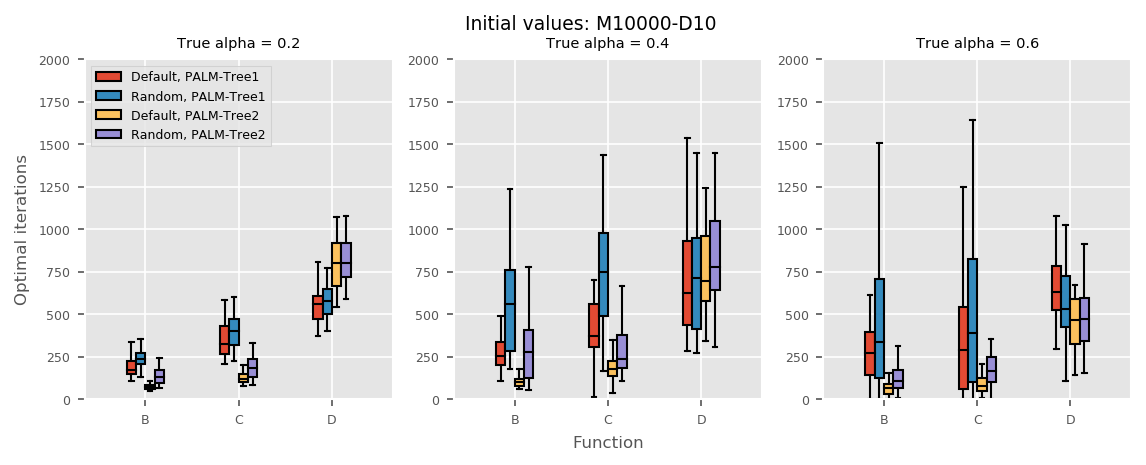

In [18]:
# Iterations
plt.style.use('ggplot')
width = 0.1
lw = 0.1
ms = 0
fs = 8
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
for i, true_alpha in enumerate(true_alphas):
    bp11 = ax[i].boxplot(np.vstack(list(opt_iters[true_alpha]['default'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
    bp12 = ax[i].boxplot(np.vstack(list(opt_iters[true_alpha]['random'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
    bp21 = ax[i].boxplot(np.vstack(list(opt_iters[true_alpha]['default'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
    bp22 = ax[i].boxplot(np.vstack(list(opt_iters[true_alpha]['random'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                                  patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

    ax[i].set_xticks(np.arange(len(Func_names)))
    ax[i].set_xticklabels([x.split('_')[1] for x in Func_names])
    ax[i].set_ylim([0, 2000])
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].set_title(f'True alpha = {true_alpha}', fontsize=7)
    if i == 1:
        ax[i].set_xlabel('Function', fontsize=fs)
    if i == 0:
        ax[i].set_ylabel('Optimal iterations', fontsize=fs)
        ax[i].legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
                     labels=["Default, PALM-Tree1", "Random, PALM-Tree1", "Default, PALM-Tree2", "Random, PALM-Tree2"],
                     loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.suptitle(f'Initial values: M{M}-D{D}', fontsize=9)
plt.show()

## 4. XGBoost vs GBM
- Investigate the computational time and performance by XGBoost and GBM.
- Large M: M = 20000, D = 50, K = 5, nrep = 50, max_iter = 5000. Set F = {A, B, C, D, E}, J = {1, 2}.
- Small M: M = 10000, D = 50, K = 2, nrep = 50, max_iter = 5000. Set F = {A, B, C, D, E}, J = {1, 2}.
- Generate data in discriminative manner.
- Evaluate performance, computational time, optimal iterations.
- Result: the performances of XGBoost and GBM are close; when M = 20000, D = 50, XGBoost is 2-3 times faster than GBM.

In [19]:
# Simulation setting
M, D, K = 20000, 50, 5
Js = [1, 2]
Func_names = ['Func_A', 'Func_B', 'Func_C', 'Func_D', 'Func_E']
v = 0.1
gam = 0
lam = 0
nrep = 50
max_iter = 5000
print_every = 1000
nthread = 1

In [20]:
# Performance
out_dir_gbm = os.path.join(out_root, f'comp_M{M}_D{D}_K{K}_gbm')
out_dir_xgb = os.path.join(out_root, f'comp_M{M}_D{D}_K{K}_xgb')
modules = ['gbm', 'xgb']
FDRs = create_nested_dict3(modules, Js, Func_names)
powers = create_nested_dict3(modules, Js, Func_names)
AUCs = create_nested_dict3(modules, Js, Func_names)
pAUCs = create_nested_dict3(modules, Js, Func_names)
times = create_nested_dict3(modules, Js, Func_names)
opt_iters = create_nested_dict3(modules, Js, Func_names)

In [21]:
# Result
for module in modules:
    exec(f'out_dir = out_dir_{module}')
    for J in Js:
        for Func_name in Func_names:
            for r in range(1, nrep+1):
                ret_opt = pd.read_csv(f'{out_dir}/{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-prioritize.csv', sep='\t')
                time = pd.read_csv(f'{out_dir}/{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-times.csv', sep='\t')
                cv_df = pd.read_csv(f'{out_dir}/{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-cv.csv', sep='\t')
                avg_Lq = np.mean(cv_df.values, axis=1)
                opt_iter = np.argmax(avg_Lq[1:]) + 1
                est_Z = ret_opt['assoc'] # risk SNPs have been identified
                perf = Perf(ret_opt['Z'], est_Z, 1 - ret_opt['post']) # FDR, power, AUC, pAUC
                FDRs[module][J][Func_name].append(perf['FDR'])
                powers[module][J][Func_name].append(perf['power']) 
                AUCs[module][J][Func_name].append(perf['AUC'])
                pAUCs[module][J][Func_name].append(perf['pAUC'])
                times[module][J][Func_name].append(time['time'].sum())
                opt_iters[module][J][Func_name].append(opt_iter)

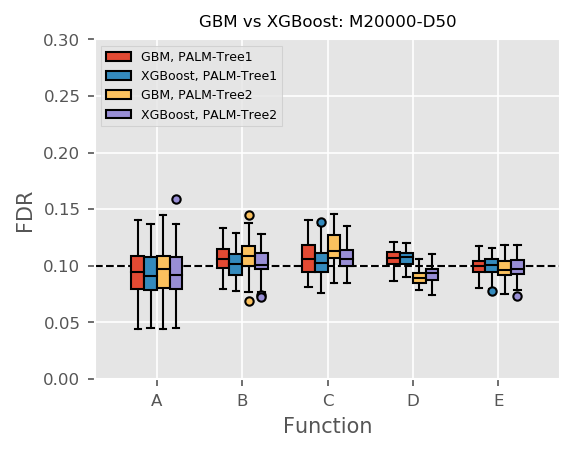

In [22]:
# FDR
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(FDRs['gbm'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(FDRs['xgb'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(FDRs['gbm'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(FDRs['xgb'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('FDR', fontsize=fs)
ax.axhline(y=0.1, color='black', ls='--', lw=1)
ax.set_ylim([0, 0.3])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
             labels=["GBM, PALM-Tree1", "XGBoost, PALM-Tree1", "GBM, PALM-Tree2", "XGBoost, PALM-Tree2"],
             loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'GBM vs XGBoost: M{M}-D{D}', fontsize=8)
plt.show()

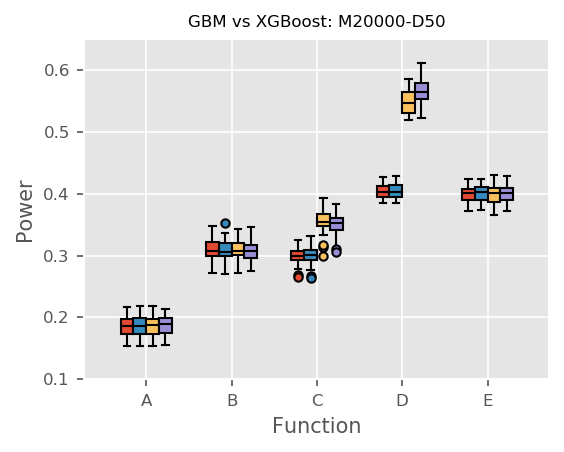

In [23]:
# Power
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(powers['gbm'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(powers['xgb'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(powers['gbm'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(powers['xgb'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Power', fontsize=fs)
ax.set_ylim([0.1, 0.65])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["GBM, PALM-Tree1", "XGBoost, PALM-Tree1", "GBM, PALM-Tree2", "XGBoost, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'GBM vs XGBoost: M{M}-D{D}', fontsize=8)
plt.show()

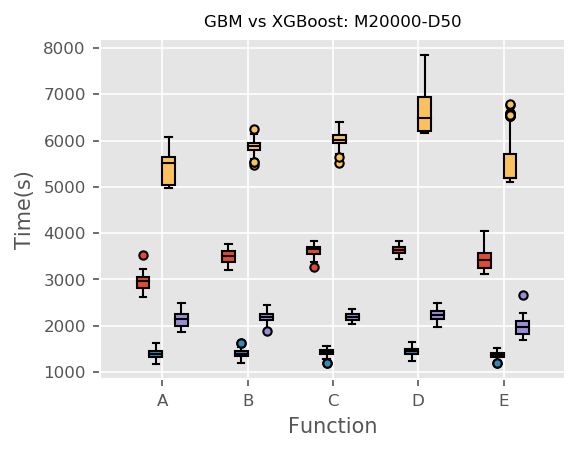

In [24]:
# Time
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(times['gbm'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(times['xgb'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(times['gbm'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(times['xgb'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Time(s)', fontsize=fs)
# ax.set_ylim([150, 1000])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["GBM, PALM-Tree1", "XGBoost, PALM-Tree1", "GBM, PALM-Tree2", "XGBoost, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6}, bbox_to_anchor=(1, 0.6))
plt.title(f'GBM vs XGBoost: M{M}-D{D}', fontsize=8)
plt.show()

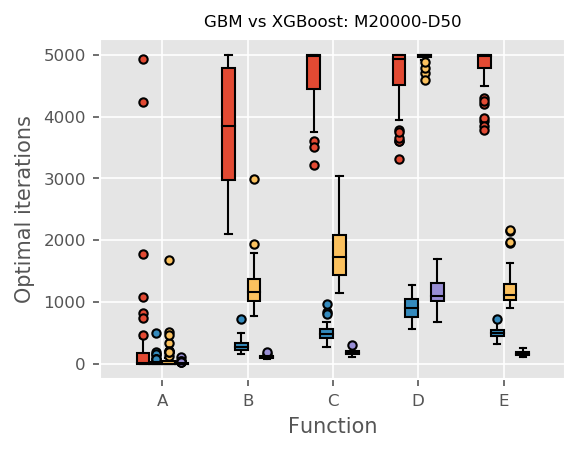

In [25]:
# Optimal iterations
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
bp11 = ax.boxplot(np.vstack(list(opt_iters['gbm'][1].values())).T, positions=np.arange(len(Func_names)) - width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(opt_iters['xgb'][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp21 = ax.boxplot(np.vstack(list(opt_iters['gbm'][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))
bp22 = ax.boxplot(np.vstack(list(opt_iters['xgb'][2].values())).T, positions=np.arange(len(Func_names)) + width * 1.5,
                              patch_artist=True, boxprops=dict(facecolor='C2'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C2', markersize=ms))

ax.set_xlabel('Function', fontsize=fs)
ax.set_xticks(np.arange(len(Func_names)))
ax.set_xticklabels([x.split('_')[1] for x in Func_names])
ax.set_ylabel('Optimal iterations', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp21["boxes"][0], bp22["boxes"][0]], 
#              labels=["GBM, PALM-Tree1", "XGBoost, PALM-Tree1", "GBM, PALM-Tree2", "XGBoost, PALM-Tree2"],
#              loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'GBM vs XGBoost: M{M}-D{D}', fontsize=8)
plt.show()

## 5. Other z-score distributions
- Investigate the influence of z-score distribution's shape.
- Fix M = 10000, D = 10, K = 2, nrep = 30, max_iter = 3000. 
- Generate data in discriminative manner, F = {B, C, D}.
- Set z-score distribution: spiky, skew, big-normal (refer to LSMM).
- Evaluate performance (FDR).
- Result: FDR control is reasonably robust under different z-score distribution shapes; only when z-score distribution shape is spiky, FDR is slighly inflated.

In [26]:
# Performance
shapes = ['spiky', 'skew', 'big-normal']
Func_names = ['Func_B', 'Func_C', 'Func_D']
M, D, K = 10000, 10, 2
nrep = 30
max_iter = 3000
v, lam, gam = 0.1, 0, 0
out_dir = os.path.join(out_root, f'shape_M{M}_D{D}_K{K}')
FDRs = create_nested_dict3(shapes, Js, Func_names)
powers = create_nested_dict3(shapes, Js, Func_names)
AUCs = create_nested_dict3(shapes, Js, Func_names)
pAUCs = create_nested_dict3(shapes, Js, Func_names)
opt_iters = create_nested_dict3(shapes, Js, Func_names)

In [27]:
for shape in shapes:
    for J in Js:
        for Func_name in Func_names:
            for r in range(1, nrep+1):
                ret_opt = pd.read_csv(f'{out_dir}/{shape}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-prioritize.csv', sep='\t')                
                cv_df = pd.read_csv(f'{out_dir}/{shape}-{Func_name}-J{J}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-cv.csv', sep='\t')                
                avg_Lq = np.mean(cv_df.values, axis=1)
                opt_iter = np.argmax(avg_Lq[1:]) + 1
                est_Z = ret_opt['assoc'] # risk SNPs have been identified
                perf = Perf(ret_opt['Z'], est_Z, 1 - ret_opt['post']) # FDR, power, AUC, pAUC
                FDRs[shape][J][Func_name].append(perf['FDR'])
                powers[shape][J][Func_name].append(perf['power']) 
                AUCs[shape][J][Func_name].append(perf['AUC'])
                pAUCs[shape][J][Func_name].append(perf['pAUC'])
                opt_iters[shape][J][Func_name].append(opt_iter)

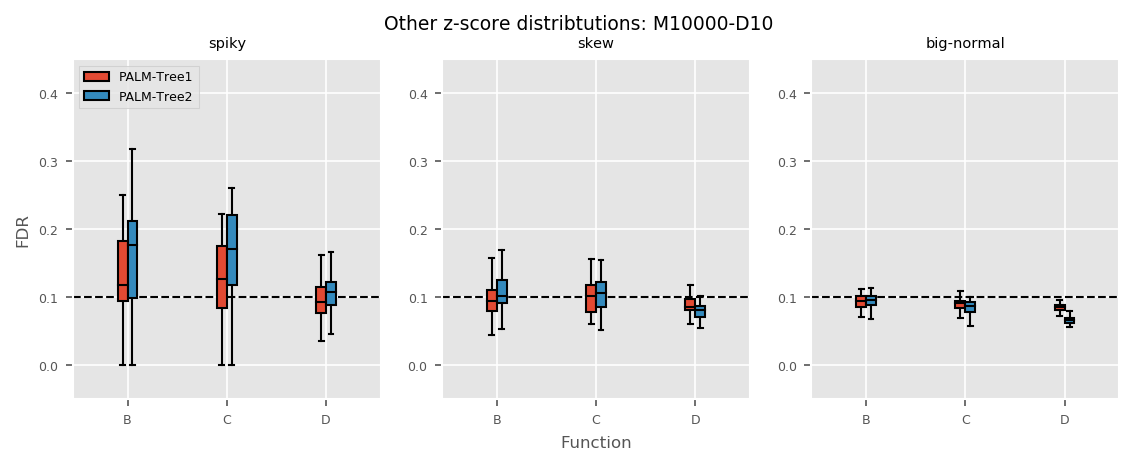

In [28]:
# FDR
plt.style.use('ggplot')
width = 0.1
lw = 0.1
ms = 0
fs = 8
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
for i, shape in enumerate(shapes):
    bp11 = ax[i].boxplot(np.vstack(list(FDRs[shape][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
    bp12 = ax[i].boxplot(np.vstack(list(FDRs[shape][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
    
    ax[i].set_xticks(np.arange(len(Func_names)))
    ax[i].set_xticklabels([x.split('_')[1] for x in Func_names])
    ax[i].set_ylim([-0.05, 0.45])
    ax[i].axhline(y=0.1, color='black', ls='--', lw=1)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].set_title(shape, fontsize=7)
    if i == 1:
        ax[i].set_xlabel('Function', fontsize=fs)
    if i == 0:
        ax[i].set_ylabel('FDR', fontsize=fs)
        ax[i].legend(handles=[bp11["boxes"][0], bp12["boxes"][0]], 
                     labels=["PALM-Tree1", "PALM-Tree2"],
                     loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.suptitle(f'Other z-score distribtutions: M{M}-D{D}', fontsize=9)
plt.show()

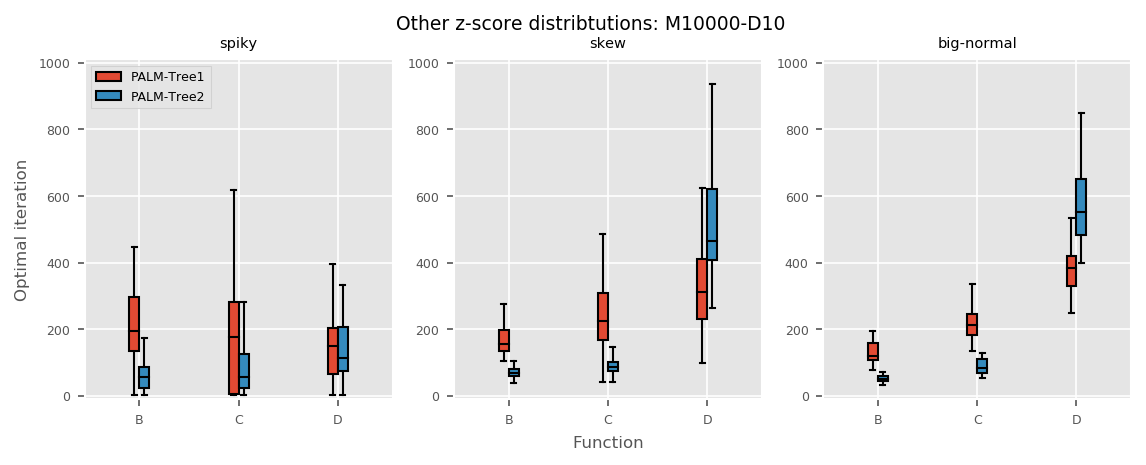

In [29]:
# Optimal iterations
plt.style.use('ggplot')
width = 0.1
lw = 0.1
ms = 0
fs = 8
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
for i, shape in enumerate(shapes):
    bp11 = ax[i].boxplot(np.vstack(list(opt_iters[shape][1].values())).T, positions=np.arange(len(Func_names)) - width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
    bp12 = ax[i].boxplot(np.vstack(list(opt_iters[shape][2].values())).T, positions=np.arange(len(Func_names)) + width * 0.5,
                                  patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                                  widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
    
    ax[i].set_xticks(np.arange(len(Func_names)))
    ax[i].set_xticklabels([x.split('_')[1] for x in Func_names])
    ax[i].set_ylim([-10, 1010])
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].set_title(shape, fontsize=7)
    if i == 1:
        ax[i].set_xlabel('Function', fontsize=fs)
    if i == 0:
        ax[i].set_ylabel('Optimal iteration', fontsize=fs)
        ax[i].legend(handles=[bp11["boxes"][0], bp12["boxes"][0]], 
                     labels=["PALM-Tree1", "PALM-Tree2"],
                     loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.suptitle(f'Other z-score distribtutions: M{M}-D{D}', fontsize=9)
plt.show()

## 6. Correlation among SNPs
- Investigate LD effects on the performance (FDR control).
- Choose SNPs and risk SNPs (M ~ 20000), set heritability -> calculate p-values using plink.
- For annotations: (1) no annotation; (2) 100 annotations (20% relevant), within 1Mb of causal SNPs 60% are annotated.
- Set different distances for identify risk SNPs -> estimate FDR.

In [30]:
Js = [1, 2]
K = 5
v = 0.1
gam = 0
lam = 0
nrep = 30
# Performance
out_dir = '../simu/real_geno'
dists = np.arange(1, 11) * 1e6
FDRs_palm = create_nested_dict2(Js, dists)
FDRs_tgm = {x: [] for x in dists}

In [31]:
# Result
for J in Js:
    for r in range(1, nrep+1):
        ret_opt = pd.read_csv(f'{out_dir}/J{J}-K{K}-v{v}-gam{gam}-lam{lam}-r{r}-PALM-tree-prioritize.csv', sep='\t')
        est_Z = ret_opt['assoc'] # risk SNPs have been identified
        est_idx = np.where(est_Z == 1)[0]
        est_BP = ret_opt.iloc[est_idx, 1].values
        true_idx = np.where(ret_opt['Z'] == 1)[0]
        true_BP = ret_opt.iloc[true_idx, 1].values
        pos = sum(est_Z)
        for dist in dists:
            if pos == 0:
                FDR = 0
            else:
                tp = 0
                for i in range(len(est_idx)):
                    if np.min(abs(est_BP[i] - true_BP)) < dist:
                        tp += 1
                FDR = 1 - tp / pos
            FDRs_palm[J][dist].append(FDR)

In [32]:
for r in range(1, nrep+1):       
    ret_tgm = pd.read_csv(f'{out_dir}/r{r}-TGM-prioritize.csv', sep='\t')
    est_Z = ret_tgm['assoc'] # risk SNPs have been identified
    est_idx = np.where(est_Z == 1)[0]
    est_BP = ret_tgm.iloc[est_idx, 1].values
    true_idx = np.where(ret_tgm['Z'] == 1)[0]
    true_BP = ret_tgm.iloc[true_idx, 1].values
    pos = sum(est_Z)
    for dist in dists:
        if pos == 0:
            FDR = 0
        else:
            tp = 0
            for i in range(len(est_idx)):
                if np.min(abs(est_BP[i] - true_BP)) < dist:
                    tp += 1
            FDR = 1 - tp / pos
        FDRs_tgm[dist].append(FDR)

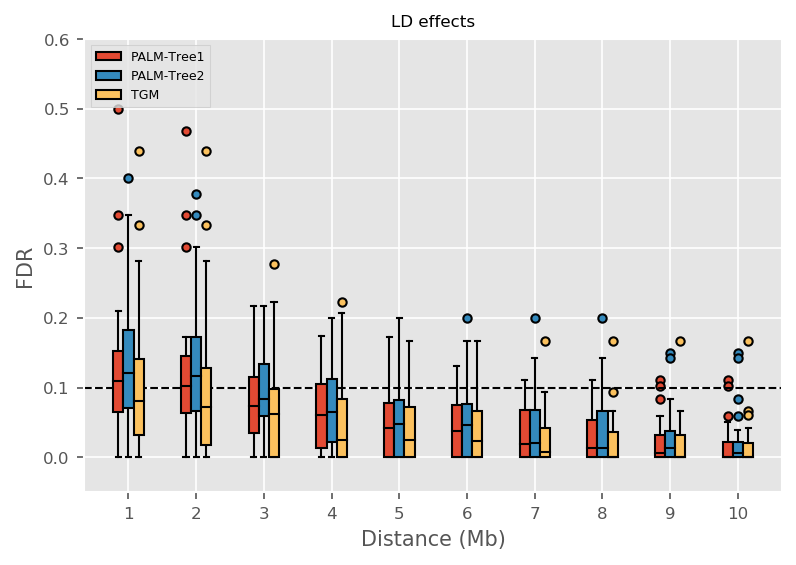

In [33]:
# FDR
plt.style.use('ggplot')
width = 0.15
lw = 0.1
ms = 4
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
bp11 = ax.boxplot(np.vstack(list(FDRs_palm[1].values())).T, positions=np.arange(1, 11) - width,
                              patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C0', markersize=ms))
bp12 = ax.boxplot(np.vstack(list(FDRs_palm[2].values())).T, positions=np.arange(1, 11),
                              patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C1', markersize=ms))
bp2 = ax.boxplot(np.vstack(list(FDRs_tgm.values())).T, positions=np.arange(1, 11) + width,
                              patch_artist=True, boxprops=dict(facecolor='C4'), medianprops=dict(color='black'),
                              widths=width, flierprops=dict(markerfacecolor='C4', markersize=ms))

ax.set_xlabel('Distance (Mb)', fontsize=fs)
ax.set_xticks(np.arange(1, 11, 1))
ax.set_xticklabels([int(x/1e6) for x in dists])
ax.set_ylabel('FDR', fontsize=fs)
ax.axhline(y=0.1, color='black', ls='--', lw=1)
ax.set_ylim([-0.05, 0.6])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(handles=[bp11["boxes"][0], bp12["boxes"][0], bp2["boxes"][0]], 
             labels=["PALM-Tree1", "PALM-Tree2", "TGM"],
             loc='upper left', ncol=1, fancybox=False, shadow=False, prop={'size': 6})
plt.title(f'LD effects', fontsize=8)
plt.show()